# **Download Dataset**

In [38]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [39]:
!kaggle datasets download -d davidhilton/apple-ripeness-levels-image-dataset

apple-ripeness-levels-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [40]:
import zipfile
zip_ref = zipfile.ZipFile('/content/apple-ripeness-levels-image-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# **Import Library**

In [41]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

base_dir = "/content/APPLE RIPENESS LEVELS IMAGE DATASET"

In [42]:
print(base_dir)

/content/APPLE RIPENESS LEVELS IMAGE DATASET


# **Data Preparation**

In [43]:
list(sorted(os.listdir(base_dir)))

['100%', '20%', '40%', '60%', '80%']

In [61]:
from pathlib import Path
import imghdr

data_dir = "/content/APPLE RIPENESS LEVELS IMAGE DATASET"
image_extensions = [".png", ".jpg", ".jpeg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [45]:
card = Image.new("RGBA", (220, 220), (255, 255, 255))
img = Image.open('/content/APPLE RIPENESS LEVELS IMAGE DATASET/100%/citra100.jpg').convert("RGBA")
x, y = img.size
card.paste(img, (0, 0, x, y), img)
card.save("/content/APPLE RIPENESS LEVELS IMAGE DATASET/100%/citra100.png", format="png")

In [62]:
batch_size = 32
img_height = 180
img_width = 180

In [63]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 500 files belonging to 5 classes.
Using 400 files for training.


In [64]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 500 files belonging to 5 classes.
Using 100 files for validation.


In [65]:
class_names = train_ds.class_names
print(class_names)

['100%', '20%', '40%', '60%', '80%']


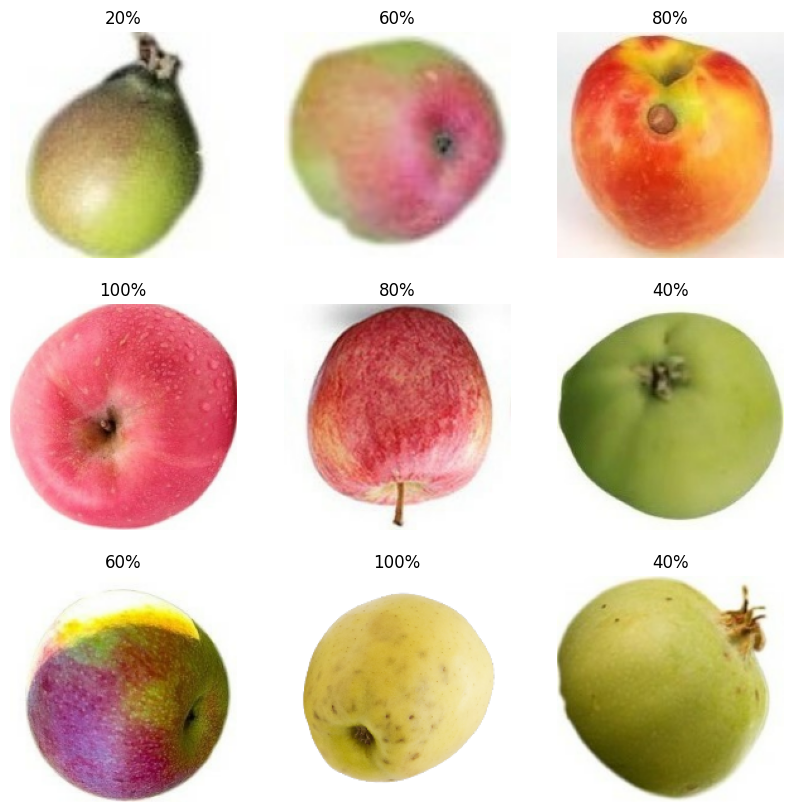

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [67]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [68]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [69]:
normalization_layer = layers.Rescaling(1./255)

In [70]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.008984578 1.0


# **Membuat Model / Sequential**

In [71]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [72]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [73]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

In [74]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
13/13 [==============================] - 14s 1s/step - loss: 1.9597 - accuracy: 0.2225 - val_loss: 1.6177 - val_accuracy: 0.1900
Epoch 2/10
13/13 [==============================] - 13s 1s/step - loss: 1.5816 - accuracy: 0.2900 - val_loss: 1.5488 - val_accuracy: 0.3500
Epoch 3/10
13/13 [==============================] - 13s 988ms/step - loss: 1.4117 - accuracy: 0.4450 - val_loss: 1.3644 - val_accuracy: 0.4300
Epoch 4/10
13/13 [==============================] - 13s 993ms/step - loss: 1.0547 - accuracy: 0.6250 - val_loss: 1.0574 - val_accuracy: 0.5400
Epoch 5/10
13/13 [==============================] - 13s 1s/step - loss: 0.8201 - accuracy: 0.6625 - val_loss: 0.8811 - val_accuracy: 0.6500
Epoch 6/10
13/13 [==============================] - 12s 975ms/step - loss: 0.7805 - accuracy: 0.6675 - val_loss: 0.9240 - val_accuracy: 0.5900
Epoch 7/10
13/13 [==============================] - 13s 988ms/step - loss: 0.6802 - accuracy: 0.7100 - val_loss: 0.9319 - val_accuracy: 0.5600
Epoch 8/

pada epoch 10, hasil akurasi validasi adalah 66%

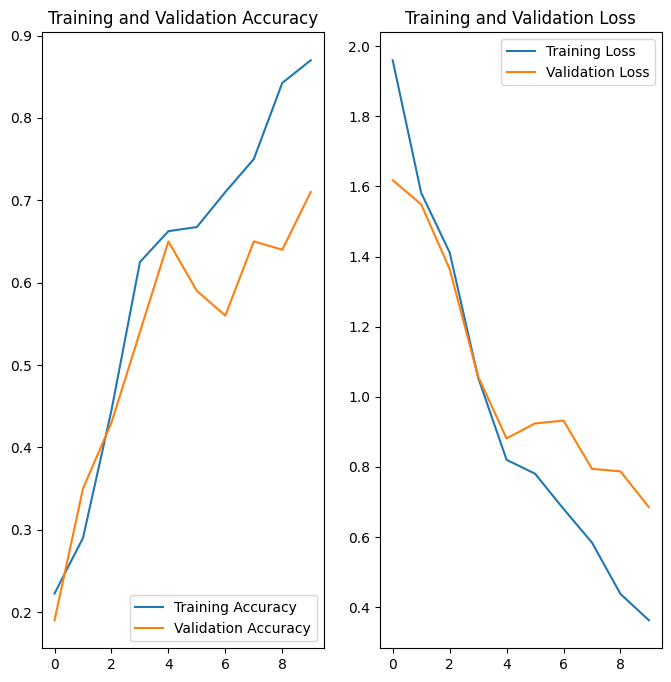

In [75]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Augmentasi**

In [76]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

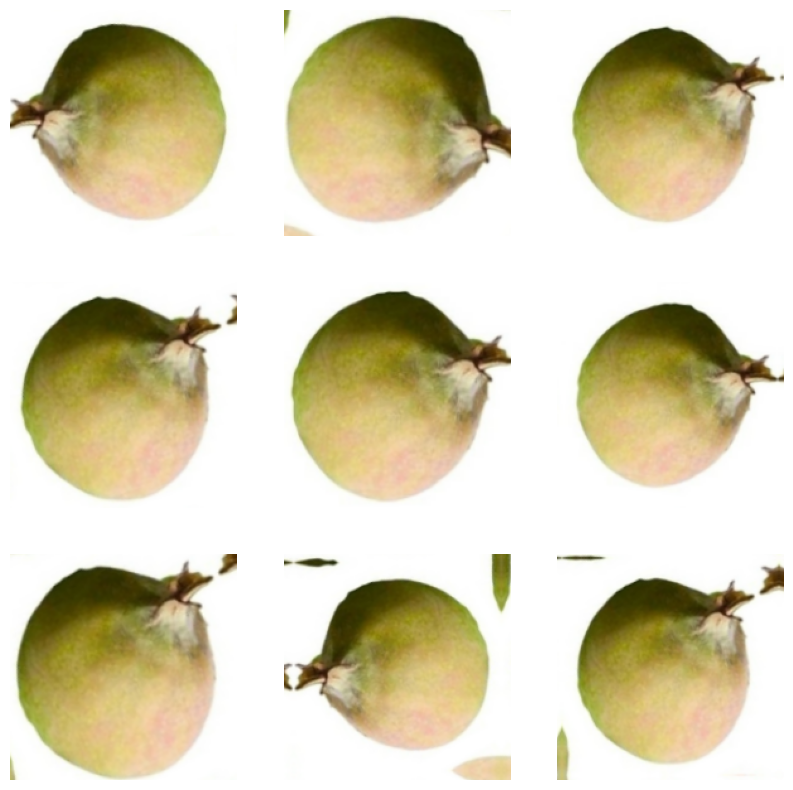

In [77]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# **Drop Out**

In [78]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# Compile ulang

In [79]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [80]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

In [81]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
13/13 [==============================] - 17s 1s/step - loss: 1.7160 - accuracy: 0.3025 - val_loss: 1.3301 - val_accuracy: 0.5800
Epoch 2/15
13/13 [==============================] - 16s 1s/step - loss: 1.0716 - accuracy: 0.5975 - val_loss: 0.8994 - val_accuracy: 0.6300
Epoch 3/15
13/13 [==============================] - 14s 1s/step - loss: 0.8582 - accuracy: 0.6725 - val_loss: 0.8609 - val_accuracy: 0.6900
Epoch 4/15
13/13 [==============================] - 15s 1s/step - loss: 0.7199 - accuracy: 0.7325 - val_loss: 0.6869 - val_accuracy: 0.7100
Epoch 5/15
13/13 [==============================] - 15s 1s/step - loss: 0.5534 - accuracy: 0.7875 - val_loss: 0.5531 - val_accuracy: 0.8300
Epoch 6/15
13/13 [==============================] - 15s 1s/step - loss: 0.4860 - accuracy: 0.8175 - val_loss: 0.4652 - val_accuracy: 0.8200
Epoch 7/15
13/13 [==============================] - 15s 1s/step - loss: 0.5040 - accuracy: 0.8050 - val_loss: 0.5772 - val_accuracy: 0.8000
Epoch 8/15
13/13 [==

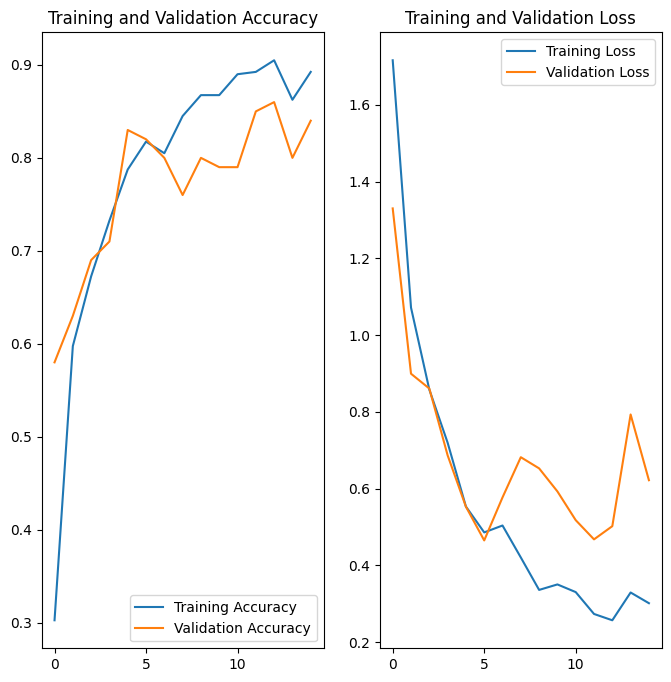

In [82]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

setelah dilakukan augmentasi dan drop out, terdapat hasil bahwa hasil akurasi validasi adalah 71% pada epoch 15

# **Percobaan model dengan gambar**

1/1 [==============================] - 0s 267ms/step
This image most likely belongs to 100% with a 99.98 percent confidence.


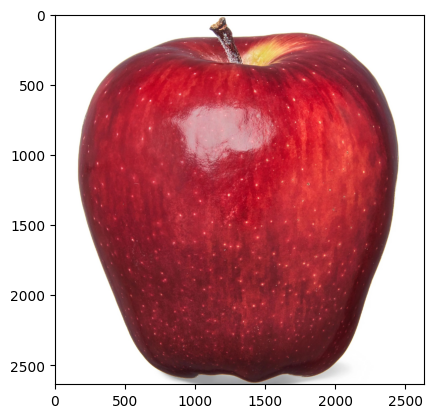

In [83]:
base_dirr = "/content/APPLE RIPENESS LEVELS IMAGE DATASET/100%/citra1.jpeg"

img = tf.keras.utils.load_img(
    base_dirr, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
im = Image.open(base_dirr)
plt.imshow(im)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 49ms/step
This image most likely belongs to 60% with a 97.48 percent confidence.


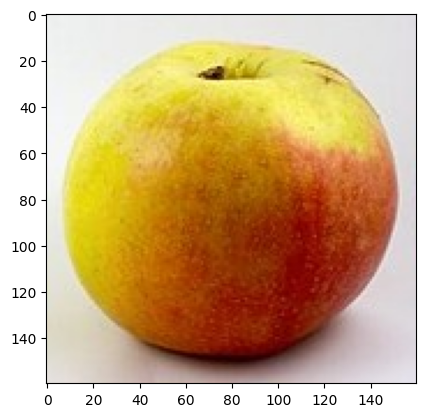

In [84]:
base_dirr = "/content/APPLE RIPENESS LEVELS IMAGE DATASET/60%/citra1.jpg"

img = tf.keras.utils.load_img(
    base_dirr, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
im = Image.open(base_dirr)
plt.imshow(im)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 47ms/step
Buah apel ini diprediksi memiliki kematangan 20% dengan 77.30 percent akurasi.
/content/apelcont.jpg


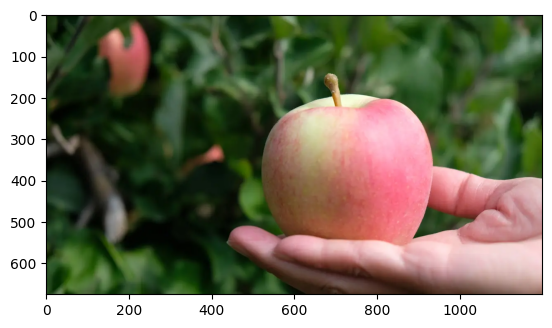

In [86]:
base_dirr = "/content/apelcont.jpg"

img = tf.keras.utils.load_img(
    base_dirr, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
im = Image.open(base_dirr)
plt.imshow(im)
print(
    "Buah apel ini diprediksi memiliki kematangan {} dengan {:.2f} percent akurasi."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
print(base_dirr)

In [88]:
from tensorflow.keras.models import save_model

save_model(model, 'kematangan_apel.hdf5')
print("Model Saved")

<ipython-input-88-7e52c23cad32>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'kematangan_apel.hdf5')


Model Saved
